In [477]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_rows", 100)

In [478]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [479]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)
i = 1
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [480]:
# Sanity check to see if SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "1"].value_counts()

rs2222162  PHENOTYPE
1          1            22
0          1            17
2          1             6
dtype: int64

In [481]:
# Sanity check to see if SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "0"].value_counts()

rs2222162  PHENOTYPE
2          0            22
1          0            19
0          0             3
dtype: int64

In [482]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
# dfAlleles = df.loc[:, "rs11684739":"rs6757306"] 500
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [483]:
# Fixing Phenotype values

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [484]:
# Re-encoding SNP of interest to generate stronger signal

#df.loc[df.PHENOTYPE == "case", ["rs2222162"]] = "2"
#df.loc[df.PHENOTYPE == "control", ["rs2222162"]] = "0"

In [485]:
# Testing to see if amplifying singal increases accuracy

#df.insert(df.columns.get_loc("rs2222162"), "rs222216_1", df["rs2222162"])
#df.insert(df.columns.get_loc("rs2222162"), "rs222216_2", df["rs2222162"])
#df.insert(df.columns.get_loc("rs2222162"), "rs222216_3", df["rs2222162"])
#df.insert(df.columns.get_loc("rs2222162"), "rs222216_4", df["rs2222162"])

In [486]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [487]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [488]:
# Converting columns to be numberical
idf = idf.apply(pd.to_numeric)

In [489]:
# Getting index of SNP of interest
idfT = idf.T
position = idfT[0].index.get_loc("rs2222162")

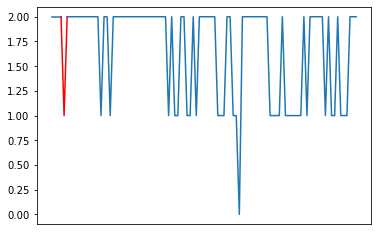

In [490]:
# Visualising entry 0 - control

position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position-1], color="tab:blue")
plt.plot(idfT[0][position-2:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")

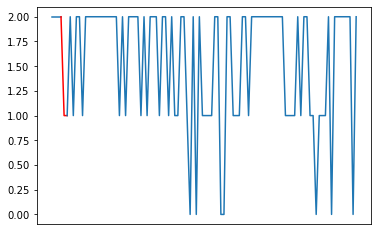

In [491]:
# Visualising entry 1 - control

position = idfT[1].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[1][0:position-1], color="tab:blue")
plt.plot(idfT[1][position-2:position+1], color="red")
plt.plot(idfT[1][position:],color="tab:blue")

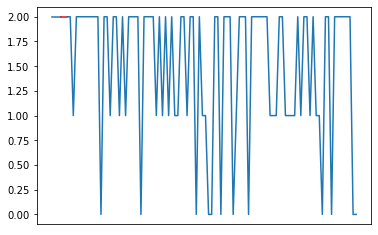

In [492]:
# Visualising entry 2 - case

position = idfT[2].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[2][0:position-1], color="tab:blue")
plt.plot(idfT[2][position-2:position+1], color="red")
plt.plot(idfT[2][position:],color="tab:blue")

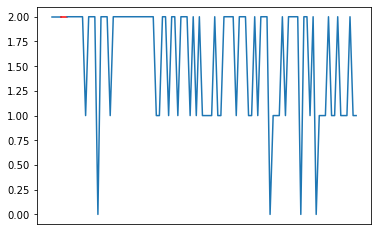

In [493]:
# Visualising entry 10 - case

position = idfT[10].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[10][0:position-1], color="tab:blue")
plt.plot(idfT[10][position-2:position+1], color="red")
plt.plot(idfT[10][position:],color="tab:blue")

In [494]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [495]:
# Classifying GWAS data using decision tree and printing results

rfc = RandomForestClassifier(n_estimators=100, max_features="auto", oob_score=True, random_state=1)
rfc.fit(xTrain, yTrain)
yPredicted = rfc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = rfc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))
print(classification_report(yTest, yPredicted))

Training accuracy score: 1.0
Testing accuracy score: 0.5
[[ 7 14]
 [ 4 11]]
              precision    recall  f1-score   support

        case       0.64      0.33      0.44        21
     control       0.44      0.73      0.55        15

    accuracy                           0.50        36
   macro avg       0.54      0.53      0.49        36
weighted avg       0.55      0.50      0.48        36



<BarContainer object of 10 artists>

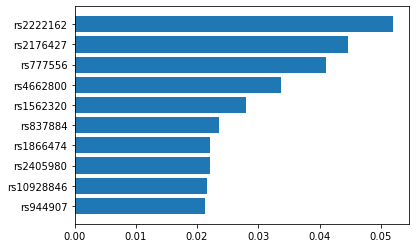

In [496]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [497]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier() 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.7169811320754716
Testing accuracy score: 0.6388888888888888
[[12  9]
 [ 4 11]]


In [498]:
# Classifying GWAS data using Gaussian Naive Bayes and printing results

gnbClf = GaussianNB() 
gnbClf.fit(xTrain, yTrain)
yPredicted = gnbClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = gnbClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.5660377358490566
Testing accuracy score: 0.4722222222222222
[[15  6]
 [13  2]]


In [499]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [500]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [501]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=["index"])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=["index"])

In [502]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [503]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with Rocket: 0.472
[[ 5 16]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.62      0.24      0.34        21
     control       0.43      0.80      0.56        15

    accuracy                           0.47        36
   macro avg       0.53      0.52      0.45        36
weighted avg       0.54      0.47      0.43        36



In [504]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="fs")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

<ipython-input-504-bacd85ef2810>:3: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="fs")
<ipython-input-504-bacd85ef2810>:3: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="fs")


Accuracy with MrSEQL: 0.583
[[11 10]
 [ 5 10]]
              precision    recall  f1-score   support

        case       0.69      0.52      0.59        21
     control       0.50      0.67      0.57        15

    accuracy                           0.58        36
   macro avg       0.59      0.60      0.58        36
weighted avg       0.61      0.58      0.58        36

